<a href="https://colab.research.google.com/github/Misetsu/Colab/blob/main/Image_Classification_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# インストール

In [ ]:
!pip install japanize_matplotlib | tail -n 1
!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1

# インポート

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from IPython.display import display

In [ ]:
# torch関連ライブラリのインポート

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [ ]:
# warning表示off
import warnings
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

# GPUチェック

In [ ]:
# デバイスの割り当て

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


#共通関数の定義

## eval_loss 損失計算用

In [ ]:
# 損失計算用
def eval_loss(loader, device, net, criterion):

    # データローダーから最初の1セットを取得する
    for images, labels in loader:
        break

    # デバイスの割り当て
    inputs = images.to(device)
    labels = labels.to(device)

    # 予測計算
    outputs = net(inputs)

    #  損失計算
    loss = criterion(outputs, labels)

    return loss

## fit 学習用

In [ ]:
# 学習用関数
def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):

    # tqdmライブラリのインポート
    from tqdm.notebook import tqdm

    base_epochs = len(history)

    for epoch in range(base_epochs, num_epochs+base_epochs):
        # 1エポックあたりの正解数(精度計算用)
        n_train_acc, n_val_acc = 0, 0
        # 1エポックあたりの累積損失(平均化前)
        train_loss, val_loss = 0, 0
        # 1エポックあたりのデータ累積件数
        n_train, n_test = 0, 0

        #訓練フェーズ
        net.train()

        for inputs, labels in tqdm(train_loader):
            # 1バッチあたりのデータ件数
            train_batch_size = len(labels)
            # 1エポックあたりのデータ累積件数
            n_train += train_batch_size

            # GPUヘ転送
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 勾配の初期化
            optimizer.zero_grad()

            # 予測計算
            outputs = net(inputs)

            # 損失計算
            loss = criterion(outputs, labels)

            # 勾配計算
            loss.backward()

            # パラメータ修正
            optimizer.step()

            # 予測ラベル導出
            predicted = torch.max(outputs, 1)[1]

            # 平均前の損失と正解数の計算
            # lossは平均計算が行われているので平均前の損失に戻して加算
            train_loss += loss.item() * train_batch_size
            n_train_acc += (predicted == labels).sum().item()

        #予測フェーズ
        net.eval()

        for inputs_test, labels_test in test_loader:
            # 1バッチあたりのデータ件数
            test_batch_size = len(labels_test)
            # 1エポックあたりのデータ累積件数
            n_test += test_batch_size

            # GPUヘ転送
            inputs_test = inputs_test.to(device)
            labels_test = labels_test.to(device)

            # 予測計算
            outputs_test = net(inputs_test)

            # 損失計算
            loss_test = criterion(outputs_test, labels_test)

            # 予測ラベル導出
            predicted_test = torch.max(outputs_test, 1)[1]

            #  平均前の損失と正解数の計算
            # lossは平均計算が行われているので平均前の損失に戻して加算
            val_loss +=  loss_test.item() * test_batch_size
            n_val_acc +=  (predicted_test == labels_test).sum().item()

        # 精度計算
        train_acc = n_train_acc / n_train
        val_acc = n_val_acc / n_test
        # 損失計算
        avg_train_loss = train_loss / n_train
        avg_val_loss = val_loss / n_test
        # 結果表示
        print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {val_acc:.5f}')
        # 記録
        item = np.array([epoch+1, avg_train_loss, train_acc, avg_val_loss, val_acc])
        history = np.vstack((history, item))
    return history

## eval_history 学習ログ解析用

In [ ]:
# 学習ログ解析

def evaluate_history(history):
    #損失と精度の確認
    print(f'初期状態: 損失: {history[0,3]:.5f} 精度: {history[0,4]:.5f}')
    print(f'最終状態: 損失: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

    num_epochs = len(history)
    unit = num_epochs / 10

    # 学習曲線の表示 (損失)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,1], 'b', label='訓練')
    plt.plot(history[:,0], history[:,3], 'k', label='検証')
    plt.xticks(np.arange(0,num_epochs+1, unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('損失')
    plt.title('学習曲線(損失)')
    plt.legend()
    plt.show()

    # 学習曲線の表示 (精度)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,2], 'b', label='訓練')
    plt.plot(history[:,0], history[:,4], 'k', label='検証')
    plt.xticks(np.arange(0,num_epochs+1,unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('精度')
    plt.title('学習曲線(精度)')
    plt.legend()
    plt.show()

## show_images_labels イメージとラベルの表示

In [ ]:
# イメージとラベル表示
def show_images_labels(loader, classes, net, device):

    # データローダーから最初の1セットを取得する
    for images, labels in loader:
        break
    # 表示数は50個とバッチサイズのうち小さい方
    n_size = min(len(images), 50)

    if net is not None:
      # デバイスの割り当て
      inputs = images.to(device)
      labels = labels.to(device)

      # 予測計算
      outputs = net(inputs)
      predicted = torch.max(outputs,1)[1]
      #images = images.to('cpu')

    # 最初のn_size個の表示
    plt.figure(figsize=(20, 15))
    for i in range(n_size):
        ax = plt.subplot(5, 10, i + 1)
        label_name = classes[labels[i]]
        # netがNoneでない場合は、予測結果もタイトルに表示する
        if net is not None:
          predicted_name = classes[predicted[i]]
          # 正解かどうかで色分けをする
          if label_name == predicted_name:
            c = 'k'
          else:
            c = 'b'
          ax.set_title(label_name + ':' + predicted_name, c=c, fontsize=20)
        # netがNoneの場合は、正解ラベルのみ表示
        else:
          ax.set_title(label_name, fontsize=20)
        # TensorをNumPyに変換
        image_np = images[i].numpy().copy()
        # 軸の順番変更 (channel, row, column) -> (row, column, channel)
        img = np.transpose(image_np, (1, 2, 0))
        # 値の範囲を[-1, 1] -> [0, 1]に戻す
        img = (img + 1)/2
        # 結果表示
        plt.imshow(img)
        ax.set_axis_off()
    plt.show()


## torch_seed 乱数固定用

In [ ]:
# PyTorch乱数固定用

def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True


# データ準備

In [ ]:
# Transformsの定義

# transformer1 1階テンソル化

transform1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.Lambda(lambda x: x.view(-1)),
])

# transformer2 正規化のみ実施

# 検証データ用 : 正規化のみ実施
transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
])

In [ ]:
# データ取得用関数 Datasets

data_root = './data'

# 訓練データセット 1階テンソル版
train_set1 = datasets.CIFAR10(
    root = data_root, train = True,
    download = True, transform = transform1)

# 検証データセット 1階テンソル版
test_set1 = datasets.CIFAR10(
    root = data_root, train = False,
    download = True, transform = transform1)

# 訓練データセット 3階テンソル版
train_set2 = datasets.CIFAR10(
    root =  data_root, train = True,
    download = True, transform = transform2)

# 検証データセット 3階テンソル版
test_set2 = datasets.CIFAR10(
    root = data_root, train = False,
    download = True, transform = transform2)

100%|██████████| 170498071/170498071 [00:05<00:00, 29638917.24it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### データセットの確認

In [ ]:
image1, label1 = train_set1[0]
image2, label2 = train_set2[0]

print(image1.shape)
print(image2.shape)

torch.Size([3072])
torch.Size([3, 32, 32])


In [ ]:
# データローダーの定義

# ミニバッチのサイズ指定
batch_size = 100

# 訓練用データローダー
# 訓練用なので、シャッフルをかける
train_loader1 = DataLoader(train_set1, batch_size=batch_size, shuffle=True)

# 検証用データローダー
# 検証時にシャッフルは不要
test_loader1 = DataLoader(test_set1,  batch_size=batch_size, shuffle=False)

# 訓練用データローダー
# 訓練用なので、シャッフルをかける
train_loader2 = DataLoader(train_set2, batch_size=batch_size, shuffle=True)

# 検証用データローダー
# 検証時にシャッフルは不要
test_loader2 = DataLoader(test_set2,  batch_size=batch_size, shuffle=False)


In [ ]:
# train_loader1から1セット取得
for images1, labels1 in train_loader1:
    break

# train_loader2から1セット取得
for images2, labels2 in train_loader2:
    break

# それぞれのshape確認
print(images1.shape)
print(images2.shape)


torch.Size([100, 3072])
torch.Size([100, 3, 32, 32])


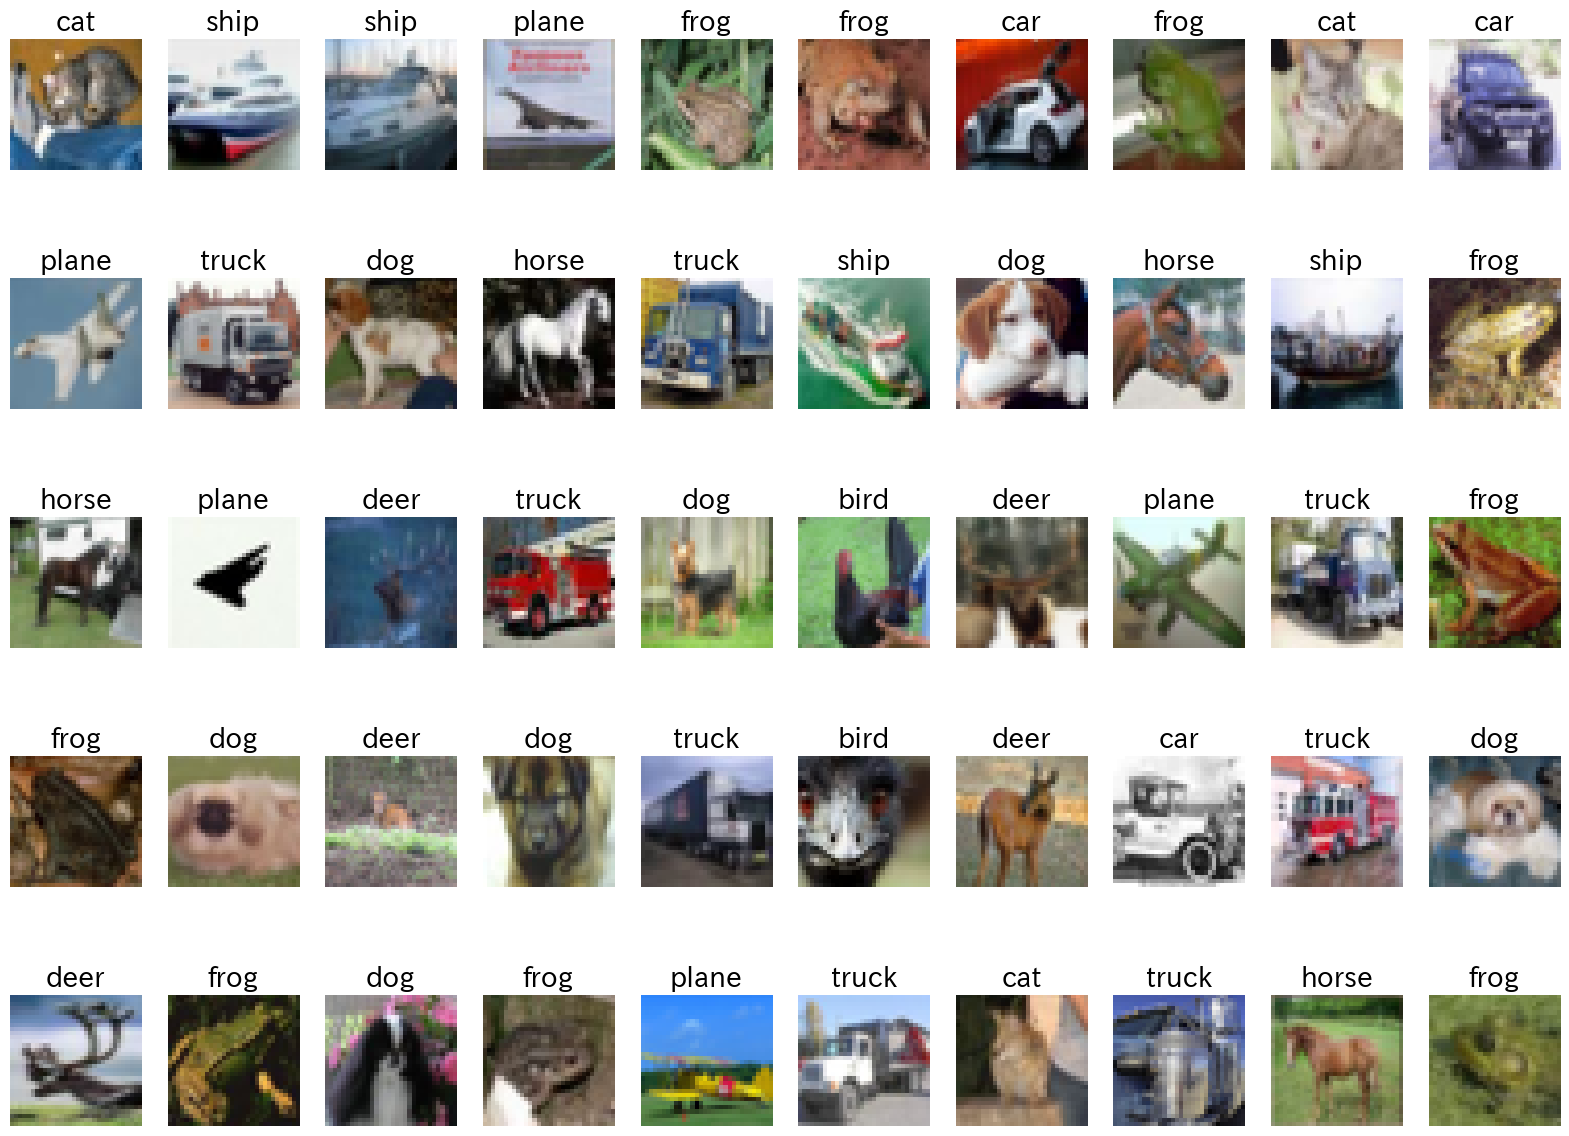

In [ ]:
# 正解ラベル定義
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 検証データ最初の50個の表示
show_images_labels(test_loader2, classes, None, None)

# モデル

## 全結合版

In [ ]:
# 入力次元数 今回は3*32*32=3072
n_input = image1.view(-1).shape[0]

# 出力次元数
# 分類先クラス数　今回は10になる
n_output = len(classes)

# 隠れ層のノード数
n_hidden = 128

# 結果確認
print(f'n_input: {n_input}  n_hidden: {n_hidden} n_output: {n_output}')

n_input: 3072  n_hidden: 128 n_output: 10


In [ ]:
# モデルの定義
# 3072入力10出力1隠れ層のニューラルネットワークモデル

class Net(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()

        # 隠れ層の定義 (隠れ層のノード数: n_hidden)
        self.l1 = nn.Linear(n_input, n_hidden)

        # 出力層の定義
        self.l2 = nn.Linear(n_hidden, n_output)

        # ReLU関数の定義
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        return x3

In [ ]:
# モデルインスタンス生成
net = Net(n_input, n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 学習率
lr = 0.01

# 最適化関数: 勾配降下法
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

In [ ]:
# モデルの概要表示

print(net)

Net(
  (l1): Linear(in_features=3072, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
)


In [ ]:
# モデルのサマリー表示

summary(net, (100,3072),depth=1)

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [100, 10]                 --
├─Linear: 1-1                            [100, 128]                393,344
├─ReLU: 1-2                              [100, 128]                --
├─Linear: 1-3                            [100, 10]                 1,290
Total params: 394,634
Trainable params: 394,634
Non-trainable params: 0
Total mult-adds (M): 39.46
Input size (MB): 1.23
Forward/backward pass size (MB): 0.11
Params size (MB): 1.58
Estimated Total Size (MB): 2.92

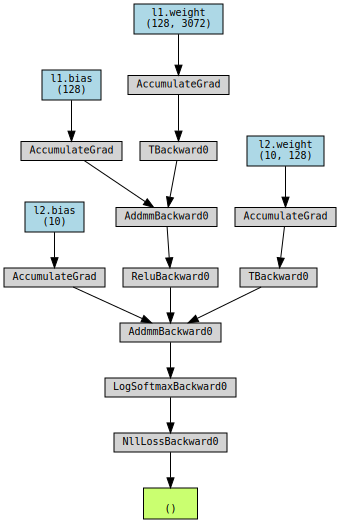

In [ ]:
# 損失計算
loss = eval_loss(test_loader1, device, net, criterion)

# 損失の計算グラフ可視化
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

## 結果(全結合版)

In [ ]:
# 乱数初期化
torch_seed()

# モデルインスタンス生成
net = Net(n_input, n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 学習率
lr = 0.01

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 50

# 評価結果記録用
history = np.zeros((0,5))

# 学習
history = fit(net, optimizer, criterion, num_epochs, train_loader1, test_loader1, device, history)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/50], loss: 1.94965 acc: 0.32200 val_loss: 1.79429, val_acc: 0.37670


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/50], loss: 1.73841 acc: 0.39572 val_loss: 1.68432, val_acc: 0.41710


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/50], loss: 1.65503 acc: 0.42402 val_loss: 1.62232, val_acc: 0.43840


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/50], loss: 1.60236 acc: 0.44248 val_loss: 1.58264, val_acc: 0.45120


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/50], loss: 1.56324 acc: 0.45530 val_loss: 1.55321, val_acc: 0.46100


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/50], loss: 1.53239 acc: 0.46754 val_loss: 1.52977, val_acc: 0.46890


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/50], loss: 1.50495 acc: 0.47748 val_loss: 1.51237, val_acc: 0.47340


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/50], loss: 1.48016 acc: 0.48604 val_loss: 1.49307, val_acc: 0.47770


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/50], loss: 1.45696 acc: 0.49572 val_loss: 1.47975, val_acc: 0.48660


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/50], loss: 1.43486 acc: 0.50454 val_loss: 1.46320, val_acc: 0.49010


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/50], loss: 1.41334 acc: 0.51112 val_loss: 1.44996, val_acc: 0.49580


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/50], loss: 1.39445 acc: 0.52008 val_loss: 1.43715, val_acc: 0.50260


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/50], loss: 1.37515 acc: 0.52678 val_loss: 1.42544, val_acc: 0.50590


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/50], loss: 1.35715 acc: 0.53504 val_loss: 1.42276, val_acc: 0.50620


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/50], loss: 1.34075 acc: 0.53924 val_loss: 1.40745, val_acc: 0.51360


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/50], loss: 1.32401 acc: 0.54590 val_loss: 1.40185, val_acc: 0.51110


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/50], loss: 1.30727 acc: 0.55108 val_loss: 1.39068, val_acc: 0.51370


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/50], loss: 1.29317 acc: 0.55716 val_loss: 1.38808, val_acc: 0.51450


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/50], loss: 1.27843 acc: 0.56146 val_loss: 1.37912, val_acc: 0.51960


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/50], loss: 1.26378 acc: 0.56694 val_loss: 1.38048, val_acc: 0.51770


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/50], loss: 1.25104 acc: 0.57062 val_loss: 1.37178, val_acc: 0.51810


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/50], loss: 1.23747 acc: 0.57726 val_loss: 1.36764, val_acc: 0.52580


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/50], loss: 1.22498 acc: 0.58008 val_loss: 1.36257, val_acc: 0.52750


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/50], loss: 1.21311 acc: 0.58402 val_loss: 1.35514, val_acc: 0.52440


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/50], loss: 1.20024 acc: 0.59174 val_loss: 1.35186, val_acc: 0.52750


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/50], loss: 1.18932 acc: 0.59382 val_loss: 1.35069, val_acc: 0.52900


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/50], loss: 1.17750 acc: 0.59886 val_loss: 1.34905, val_acc: 0.52720


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/50], loss: 1.16652 acc: 0.60206 val_loss: 1.34329, val_acc: 0.52960


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/50], loss: 1.15559 acc: 0.60540 val_loss: 1.34190, val_acc: 0.52840


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/50], loss: 1.14474 acc: 0.60976 val_loss: 1.34557, val_acc: 0.53010


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [31/50], loss: 1.13463 acc: 0.61516 val_loss: 1.34062, val_acc: 0.53010


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [32/50], loss: 1.12405 acc: 0.61786 val_loss: 1.33800, val_acc: 0.52870


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [33/50], loss: 1.11450 acc: 0.62116 val_loss: 1.33794, val_acc: 0.53070


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [34/50], loss: 1.10485 acc: 0.62616 val_loss: 1.34166, val_acc: 0.52810


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [35/50], loss: 1.09511 acc: 0.62846 val_loss: 1.34095, val_acc: 0.52730


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [36/50], loss: 1.08563 acc: 0.63218 val_loss: 1.33393, val_acc: 0.53210


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [37/50], loss: 1.07644 acc: 0.63564 val_loss: 1.33957, val_acc: 0.52820


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [38/50], loss: 1.06731 acc: 0.63948 val_loss: 1.33592, val_acc: 0.53080


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [39/50], loss: 1.05906 acc: 0.64206 val_loss: 1.34138, val_acc: 0.53010


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [40/50], loss: 1.05024 acc: 0.64520 val_loss: 1.34845, val_acc: 0.52430


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [41/50], loss: 1.04051 acc: 0.64904 val_loss: 1.33987, val_acc: 0.52840


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [42/50], loss: 1.03267 acc: 0.65044 val_loss: 1.34742, val_acc: 0.52820


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [43/50], loss: 1.02514 acc: 0.65418 val_loss: 1.34666, val_acc: 0.52500


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [44/50], loss: 1.01624 acc: 0.65598 val_loss: 1.34640, val_acc: 0.52490


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [45/50], loss: 1.00700 acc: 0.65942 val_loss: 1.34491, val_acc: 0.52630


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [46/50], loss: 1.00024 acc: 0.66198 val_loss: 1.34359, val_acc: 0.53020


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.99316 acc: 0.66424 val_loss: 1.34748, val_acc: 0.52600


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.98445 acc: 0.66810 val_loss: 1.35069, val_acc: 0.52960


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.97678 acc: 0.67072 val_loss: 1.36345, val_acc: 0.52110


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.97024 acc: 0.67242 val_loss: 1.35274, val_acc: 0.53100


初期状態: 損失: 1.79429 精度: 0.37670
最終状態: 損失: 1.35274 精度: 0.53100


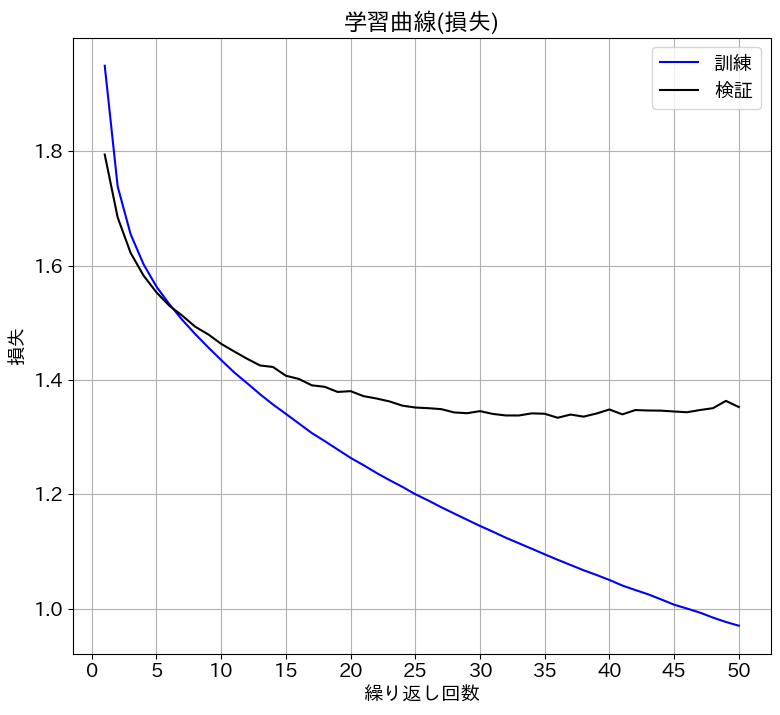

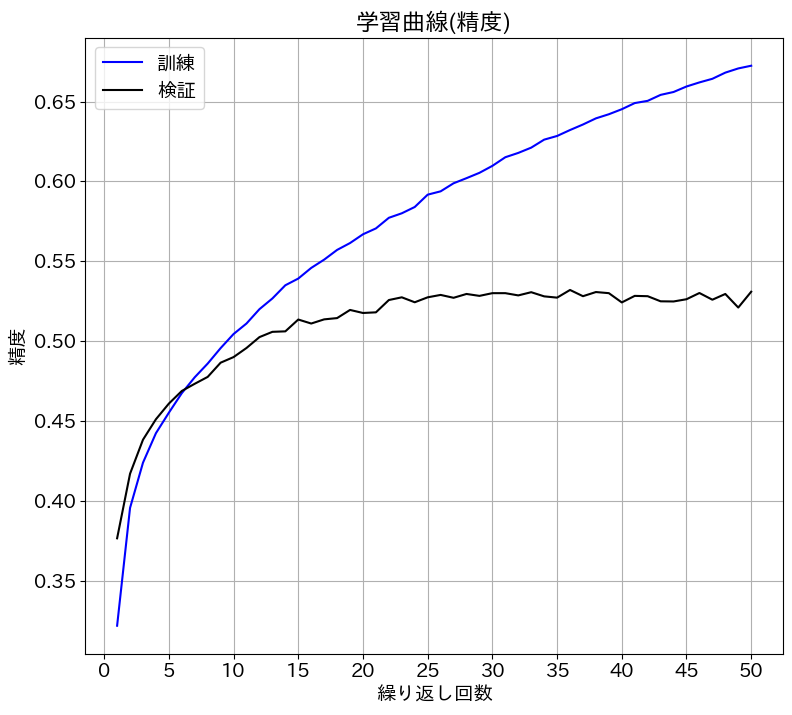

In [ ]:
# 評価

evaluate_history(history)

## CNN

In [ ]:
class CNN(nn.Module):
  def __init__(self, n_output, n_hidden):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.conv2 = nn.Conv2d(32, 32, 3)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d((2,2))
    self.flatten = nn.Flatten()
    self.l1 = nn.Linear(6272, n_hidden)
    self.l2 = nn.Linear(n_hidden, n_output)

    self.features = nn.Sequential(
        self.conv1,
        self.relu,
        self.conv2,
        self.relu,
        self.maxpool)

    self.classifier = nn.Sequential(
       self.l1,
       self.relu,
       self.l2)

  def forward(self, x):
    x1 = self.features(x)
    x2 = self.flatten(x1)
    x3 = self.classifier(x2)
    return x3

In [ ]:
# モデルインスタンス生成
net = CNN(n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 学習率
lr = 0.01

# 最適化関数: 勾配降下法
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

In [ ]:
# モデルの概要表示

print(net)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): Linear(in_features=6272, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=10, bias=True)
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=6272, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [ ]:
# モデルのサマリー表示

summary(net,(100,3,32,32),depth=1)

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [100, 10]                 --
├─Sequential: 1-1                        [100, 32, 14, 14]         10,144
├─Sequential: 1-4                        --                        (recursive)
├─Sequential: 1-5                        --                        (recursive)
├─Sequential: 1-4                        --                        (recursive)
├─Sequential: 1-5                        --                        (recursive)
├─Flatten: 1-6                           [100, 6272]               --
├─Sequential: 1-7                        [100, 10]                 804,234
Total params: 823,626
Trainable params: 823,626
Non-trainable params: 0
Total mult-adds (M): 886.11
Input size (MB): 1.23
Forward/backward pass size (MB): 43.22
Params size (MB): 3.26
Estimated Total Size (MB): 47.71

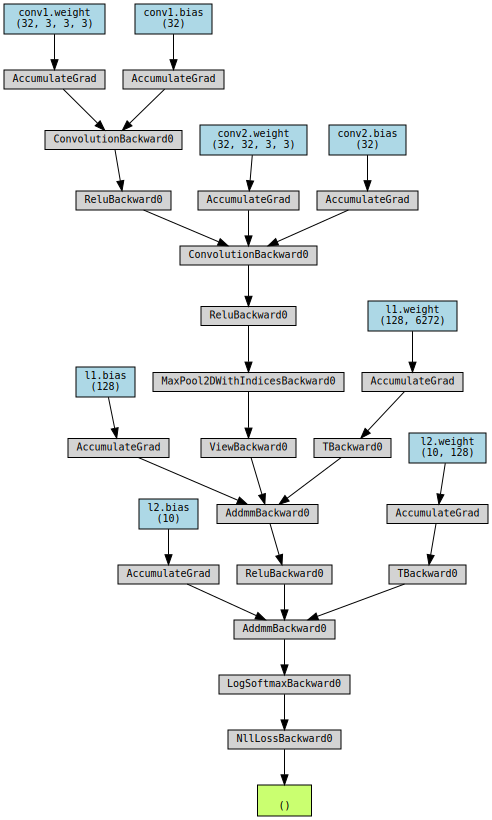

In [ ]:
# 損失計算
loss = eval_loss(test_loader2, device, net, criterion)

# 損失の計算グラフ可視化
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

## 結果(CNN)

In [ ]:
# 乱数初期化
torch_seed()

# モデルインスタンス生成
net = CNN(n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 学習率
lr = 0.01

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 50

# 評価結果記録用
history2 = np.zeros((0,5))

# 学習
history2 = fit(net, optimizer, criterion, num_epochs, train_loader2, test_loader2, device, history2)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/50], loss: 2.08249 acc: 0.26090 val_loss: 1.86598, val_acc: 0.34700


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/50], loss: 1.78095 acc: 0.37272 val_loss: 1.67710, val_acc: 0.40920


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/50], loss: 1.61349 acc: 0.43052 val_loss: 1.53057, val_acc: 0.46120


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/50], loss: 1.48564 acc: 0.47324 val_loss: 1.44865, val_acc: 0.48980


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/50], loss: 1.40876 acc: 0.49944 val_loss: 1.37046, val_acc: 0.51260


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/50], loss: 1.35032 acc: 0.52060 val_loss: 1.33441, val_acc: 0.52580


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/50], loss: 1.30367 acc: 0.53680 val_loss: 1.29159, val_acc: 0.53820


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/50], loss: 1.25287 acc: 0.55438 val_loss: 1.25376, val_acc: 0.55080


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/50], loss: 1.20528 acc: 0.57446 val_loss: 1.23764, val_acc: 0.56100


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/50], loss: 1.15810 acc: 0.59162 val_loss: 1.18371, val_acc: 0.57970


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/50], loss: 1.11686 acc: 0.60818 val_loss: 1.16334, val_acc: 0.58870


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/50], loss: 1.07816 acc: 0.62298 val_loss: 1.16897, val_acc: 0.58230


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/50], loss: 1.03672 acc: 0.63614 val_loss: 1.11161, val_acc: 0.60630


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.99834 acc: 0.64994 val_loss: 1.08928, val_acc: 0.61230


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.96007 acc: 0.66374 val_loss: 1.10685, val_acc: 0.60570


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.92308 acc: 0.67652 val_loss: 1.05517, val_acc: 0.63070


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.88271 acc: 0.69210 val_loss: 1.06885, val_acc: 0.62380


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.84779 acc: 0.70298 val_loss: 1.01324, val_acc: 0.64730


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.80936 acc: 0.71810 val_loss: 1.02051, val_acc: 0.64320


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.77401 acc: 0.73080 val_loss: 1.04032, val_acc: 0.63560


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.73930 acc: 0.74168 val_loss: 1.00149, val_acc: 0.65200


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.70190 acc: 0.75714 val_loss: 1.01413, val_acc: 0.65460


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.67430 acc: 0.76650 val_loss: 0.99440, val_acc: 0.65710


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.63716 acc: 0.78006 val_loss: 1.00282, val_acc: 0.66090


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.60381 acc: 0.79228 val_loss: 0.99966, val_acc: 0.66590


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.56834 acc: 0.80506 val_loss: 1.05143, val_acc: 0.64880


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.54003 acc: 0.81536 val_loss: 1.05866, val_acc: 0.65910


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.50783 acc: 0.82734 val_loss: 1.13392, val_acc: 0.64010


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.47302 acc: 0.84030 val_loss: 1.05649, val_acc: 0.66180


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.44150 acc: 0.85184 val_loss: 1.10336, val_acc: 0.65900


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.40812 acc: 0.86278 val_loss: 1.09804, val_acc: 0.66520


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.37865 acc: 0.87354 val_loss: 1.15080, val_acc: 0.65820


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.35097 acc: 0.88440 val_loss: 1.12799, val_acc: 0.66500


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.32232 acc: 0.89282 val_loss: 1.23104, val_acc: 0.65410


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.29230 acc: 0.90614 val_loss: 1.29071, val_acc: 0.65100


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.26966 acc: 0.91266 val_loss: 1.27047, val_acc: 0.65650


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.23760 acc: 0.92550 val_loss: 1.27482, val_acc: 0.66710


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.21358 acc: 0.93376 val_loss: 1.31816, val_acc: 0.66330


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.19097 acc: 0.94246 val_loss: 1.38747, val_acc: 0.65920


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.17543 acc: 0.95076 val_loss: 1.44456, val_acc: 0.65450


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.14559 acc: 0.96020 val_loss: 1.56184, val_acc: 0.65040


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.13345 acc: 0.96386 val_loss: 1.55645, val_acc: 0.64860


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.10118 acc: 0.97806 val_loss: 1.61254, val_acc: 0.65000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.09341 acc: 0.98046 val_loss: 1.60006, val_acc: 0.65980


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.08262 acc: 0.98336 val_loss: 1.64789, val_acc: 0.66500


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.09434 acc: 0.98172 val_loss: 1.73543, val_acc: 0.64850


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.04917 acc: 0.99390 val_loss: 1.71951, val_acc: 0.66100


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.03656 acc: 0.99662 val_loss: 1.79099, val_acc: 0.66180


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.02922 acc: 0.99770 val_loss: 1.83995, val_acc: 0.66650


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.02372 acc: 0.99898 val_loss: 1.89637, val_acc: 0.66200


初期状態: 損失: 1.86598 精度: 0.34700
最終状態: 損失: 1.89637 精度: 0.66200


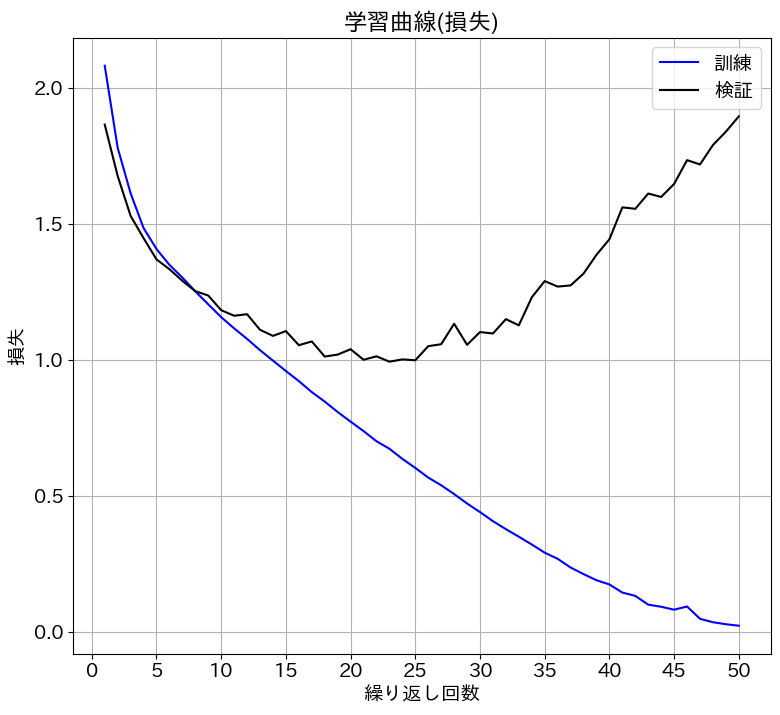

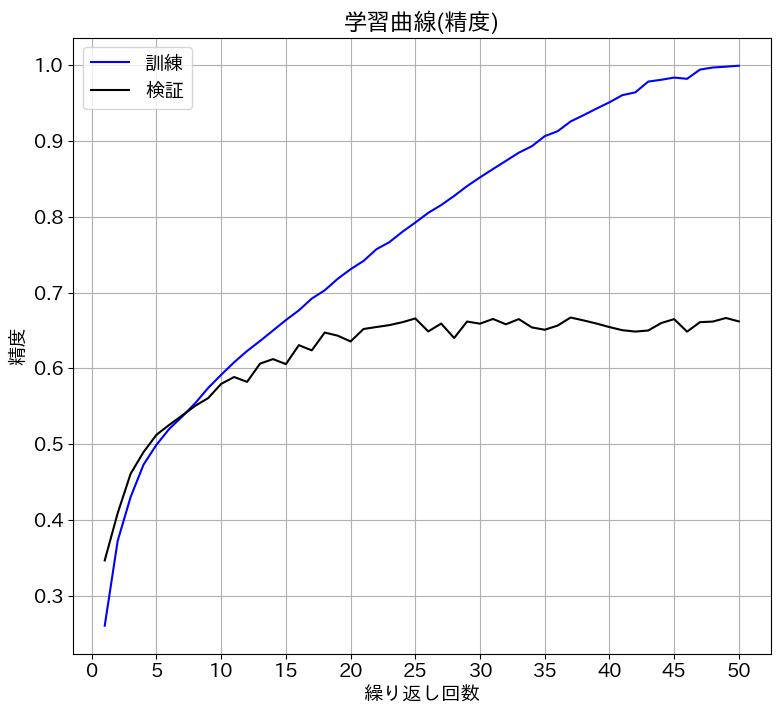

In [ ]:
# 評価

evaluate_history(history2)

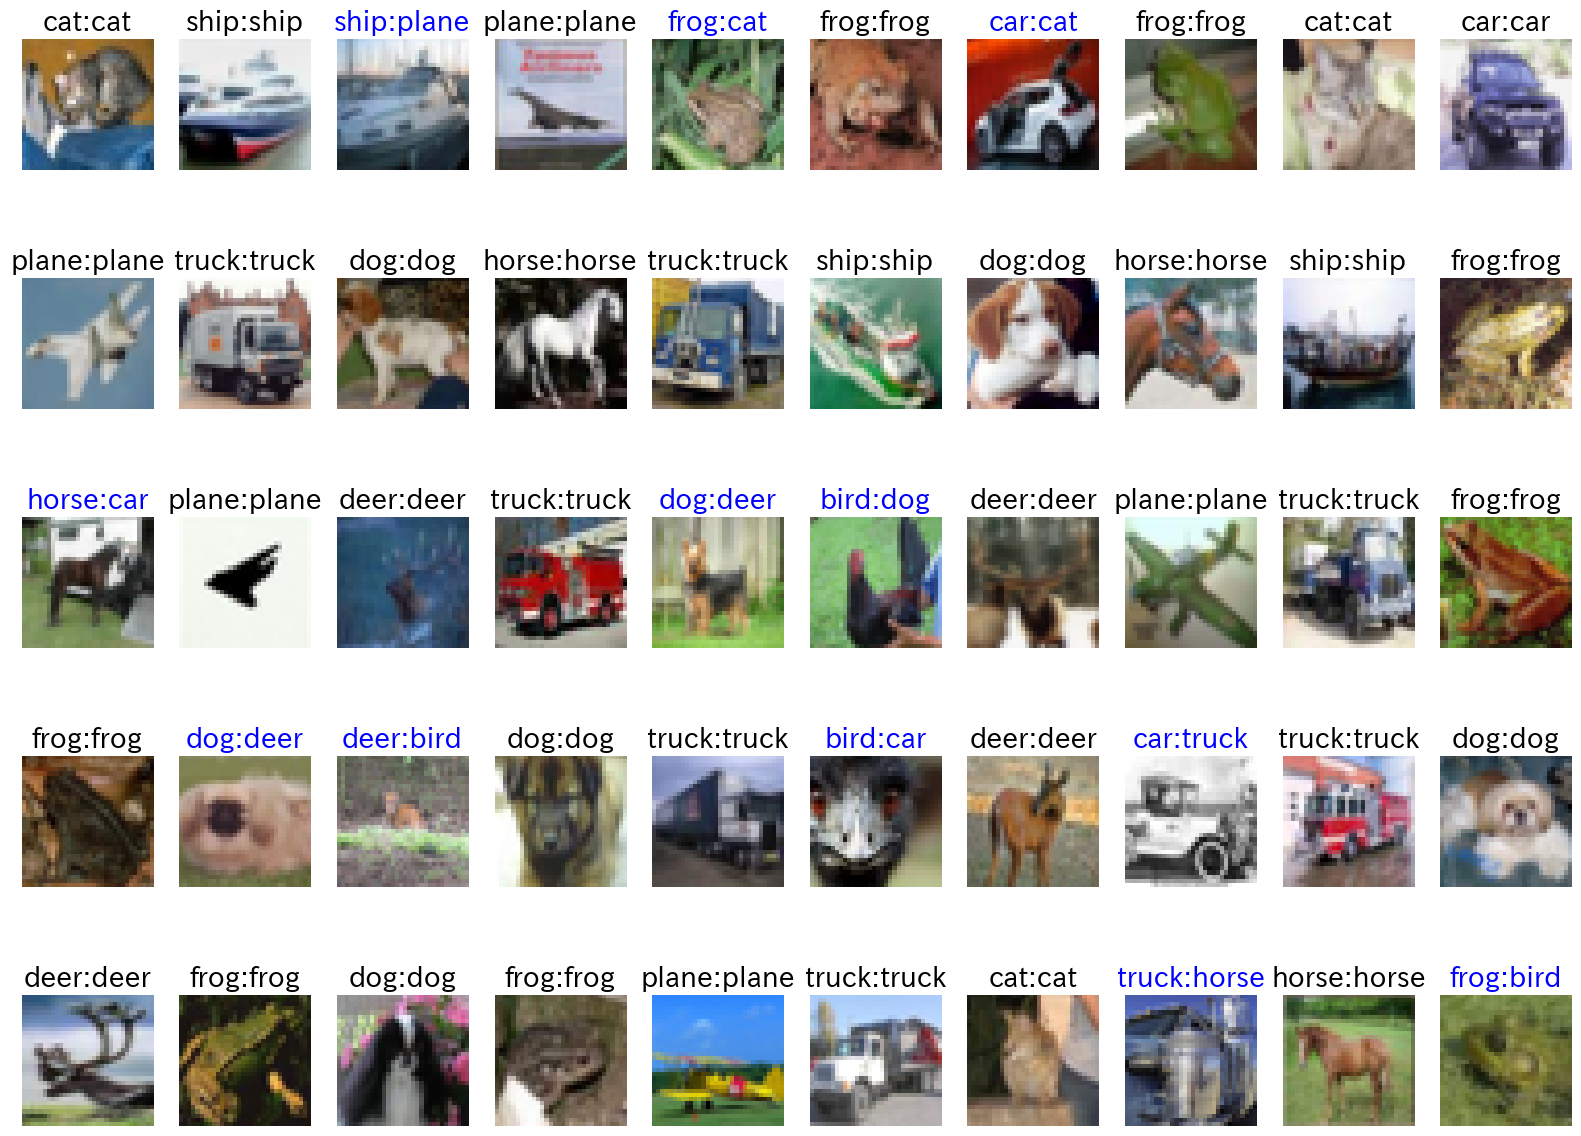

In [ ]:
# 最初の50個の表示

show_images_labels(test_loader2, classes, net, device)

## AlexNet

In [ ]:
n_hidden = 4096

In [ ]:
# org for image size 224*224

class AlexNet(nn.Module):
  def __init__(self, n_output, n_hidden):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 64, 3, stride=4, padding=2)
    self.conv2 = nn.Conv2d(64, 192, 3, padding=2)
    self.conv3 = nn.Conv2d(192, 384, 3, padding=1)
    self.conv4 = nn.Conv2d(384, 256, 3, padding=1)
    self.conv5 = nn.Conv2d(256, 256, 3, padding=1)
    self.relu = nn.ReLU(inplace=True)
    self.dropout = nn.Dropout(p=0.5)
    self.maxpool = nn.MaxPool2d((3, 3), stride=(2, 2))
    self.flatten = nn.Flatten()
    self.l1 = nn.Linear(256*6*6, n_hidden)
    self.l2 = nn.Linear(n_hidden, n_hidden)
    self.l3 = nn.Linear(n_hidden, n_output)

    self.features = nn.Sequential(
        self.conv1,
        self.relu,
        self.maxpool,
        self.conv2,
        self.relu,
        self.maxpool,
        self.conv3,
        self.relu,
        self.conv4,
        self.relu,
        self.conv5,
        self.relu,
        self.maxpool
        )

    self.classifier = nn.Sequential(
       self.l1,
       self.relu,
       self.dropout,
       self.l2,
       self.relu,
       self.dropout,
       self.l3)

  def forward(self, x):
    x1 = self.features(x)
    x2 = self.flatten(x1)
    x3 = self.classifier(x2)
    return x3

## LeNet

In [ ]:
class LeNet(nn.Module):
  def __init__(self, n_output, n_hidden):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 5, padding=2)
    self.conv2 = nn.Conv2d(32, 32, 5)
    self.sigmoid = nn.Sigmoid()
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d((2, 2), stride=(2, 2))
    self.flatten = nn.Flatten()
    self.l1 = nn.Linear(32*6*6, 120)
    self.l2 = nn.Linear(120, 84)
    self.l3 = nn.Linear(84, n_output)

    self.features = nn.Sequential(
        self.conv1,
        # self.sigmoid,
        self.relu,
        self.maxpool,
        self.conv2,
        # self.sigmoid,
        self.relu,
        self.maxpool
        )

    self.classifier = nn.Sequential(
       self.l1,
       # self.sigmoid,
       self.relu,
       self.l2,
       # self.sigmoid,
       self.relu,
       self.l3)

  def forward(self, x):
    x1 = self.features(x)
    x2 = self.flatten(x1)
    x3 = self.classifier(x2)
    return x3

In [ ]:
net = LeNet(n_output, n_hidden).to(device)

In [ ]:
inputs = torch.randn(100, 3, 32, 32).to(device)
output = net.features(inputs)
output.shape

torch.Size([100, 32, 6, 6])

In [ ]:
# モデルの概要表示

print(net)

LeNet(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (sigmoid): Sigmoid()
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): Linear(in_features=1152, out_features=120, bias=True)
  (l2): Linear(in_features=120, out_features=84, bias=True)
  (l3): Linear(in_features=84, out_features=10, bias=True)
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=1152, out_featur

## 結果(LeNet)

In [ ]:
# 乱数初期化
torch_seed()

# モデルインスタンス生成
net = LeNet(n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 学習率
lr = 0.02

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 30

# 評価結果記録用
history3 = np.zeros((0,5))

# 学習
history3 = fit(net, optimizer, criterion, num_epochs, train_loader2, test_loader2, device, history3)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/30], loss: 2.20621 acc: 0.17632 val_loss: 1.96837, val_acc: 0.29910


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/30], loss: 1.80427 acc: 0.34680 val_loss: 1.72809, val_acc: 0.37520


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/30], loss: 1.55936 acc: 0.43268 val_loss: 1.46581, val_acc: 0.46420


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/30], loss: 1.43267 acc: 0.48368 val_loss: 1.40528, val_acc: 0.50000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/30], loss: 1.33979 acc: 0.51972 val_loss: 1.34907, val_acc: 0.53010


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/30], loss: 1.26258 acc: 0.55098 val_loss: 1.24555, val_acc: 0.55710


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/30], loss: 1.19091 acc: 0.57846 val_loss: 1.16825, val_acc: 0.58740


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/30], loss: 1.12515 acc: 0.60366 val_loss: 1.11749, val_acc: 0.59960


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/30], loss: 1.06485 acc: 0.62428 val_loss: 1.06561, val_acc: 0.62970


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/30], loss: 1.01513 acc: 0.64624 val_loss: 1.03470, val_acc: 0.63990


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/30], loss: 0.96632 acc: 0.66104 val_loss: 1.00909, val_acc: 0.64670


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/30], loss: 0.92664 acc: 0.67412 val_loss: 0.99160, val_acc: 0.65670


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/30], loss: 0.88993 acc: 0.68896 val_loss: 0.95523, val_acc: 0.67000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/30], loss: 0.84908 acc: 0.70246 val_loss: 0.94816, val_acc: 0.66920


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/30], loss: 0.81672 acc: 0.71734 val_loss: 0.94787, val_acc: 0.66930


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/30], loss: 0.78341 acc: 0.72614 val_loss: 0.95672, val_acc: 0.67210


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/30], loss: 0.75111 acc: 0.73628 val_loss: 0.87571, val_acc: 0.69550


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/30], loss: 0.71762 acc: 0.74930 val_loss: 0.87076, val_acc: 0.69940


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/30], loss: 0.69181 acc: 0.75978 val_loss: 0.88333, val_acc: 0.69290


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/30], loss: 0.65957 acc: 0.77098 val_loss: 0.85796, val_acc: 0.71070


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/30], loss: 0.63559 acc: 0.77850 val_loss: 0.86739, val_acc: 0.70230


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/30], loss: 0.60876 acc: 0.78850 val_loss: 0.90133, val_acc: 0.70130


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/30], loss: 0.58072 acc: 0.79840 val_loss: 0.86764, val_acc: 0.70660


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/30], loss: 0.55442 acc: 0.80746 val_loss: 0.89241, val_acc: 0.70510


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/30], loss: 0.53018 acc: 0.81392 val_loss: 0.89184, val_acc: 0.70760


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/30], loss: 0.51135 acc: 0.82142 val_loss: 0.86555, val_acc: 0.71890


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/30], loss: 0.48520 acc: 0.83050 val_loss: 0.88240, val_acc: 0.71370


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/30], loss: 0.46198 acc: 0.83678 val_loss: 0.92531, val_acc: 0.70850


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/30], loss: 0.44329 acc: 0.84358 val_loss: 0.93530, val_acc: 0.70560


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/30], loss: 0.41687 acc: 0.85320 val_loss: 0.92216, val_acc: 0.71360


初期状態: 損失: 1.96837 精度: 0.29910
最終状態: 損失: 0.92216 精度: 0.71360


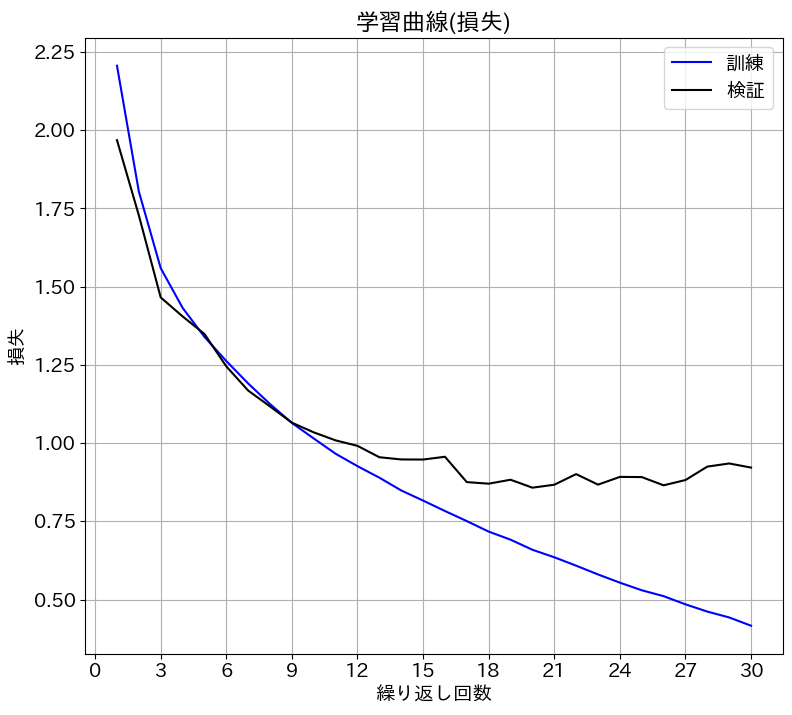

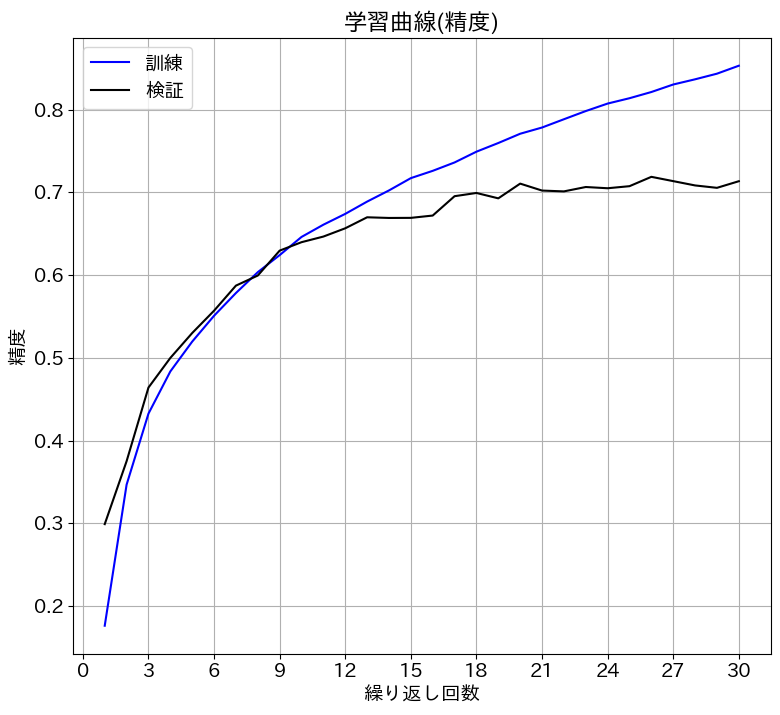

In [ ]:
# 評価

evaluate_history(history3)